# Scrape The Web -> Preprocess and Do Some Cleaning -> Save To csv For Further Analysis
I will be using BeautifulSoup, Requests, Pandas, and NumPy to scrape the page https://scrapsfromtheloft.com/tag/stand-up-transcripts/ in order to return a csv file containing over 300 stand-up comedy transcripts

### Scrape the main directory page to get links, tags, titles, and date posted
- The directory page is set up with title cards representing each comedy special. Each card is in a div and contains everything needed to get the full transcripts and some meta data.
- Infinite scroll presents some difficulty because all of the divs are not made available on page load. The solution was found by examining the url structure and simply adding "/page/[page num]" to the url. [page num] grows on each iteration of a while loop. Once a 404 error is observed the while loop is broken.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

def scrape_dir_page():
    # Initialize empty lists where scrapped data will be stored
    titles = []
    links = []
    date_posted = []
    tags = []
    page_num = 1

    # While loop to iterate through all pages in the infinite scroll. Break on a 404 error
    while (True): 
        dir_url = 'https://scrapsfromtheloft.com/tag/stand-up-transcripts/' + 'page/' + str(page_num)

        # Request page content
        dir_page_response = requests.get(dir_url, timeout=120)
        
        # Exit loop when we run out of pages and get a 404 error
        if (dir_page_response.status_code == 404):
            print(f'Total pages scraped before error: {page_num - 1}')
            break 
        else:
            # Parse and turn into soup
            dir_page_soup = BeautifulSoup(dir_page_response.content, 'html.parser')
            # Take title-cards as containers
            dir_containers = dir_page_soup.find_all('div', attrs={'class':'fusion-post-content post-content'}) 

            # Strip titles, links, posting dates, and tags from each card
            for i in dir_containers:
                titles.append(i.h2.text)
                links.append(i.a['href'])
                # Posted date is the 4th span item (index 3)
                date_posted.append(i.select('span')[3].get_text()) 
                # Tags are the 7th span item. The first 6 characters appearing in each one is "tags: ", so those are skipped with [5:]
                tags.append(i.select('span')[6].get_text(strip=True)[5:]) 
            page_num += 1     
    return titles, links, date_posted, tags

titles, links, date_posted, tags = scrape_dir_page()

# Create a DataFrame object with data lists
df = pd.DataFrame({'title': titles,
                  'tags': tags,
                   'date_posted':date_posted,
                   'link': links})

print(f'Length : {len(df)}')

df.head()

Total pages scraped before error: 28
Length : 330


,title,tags,date_posted,link
0,RUSSELL PETERS: DEPORTED (2020) – FULL TRANSCRIPT,"Russell Peters,Stand-up transcripts","May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...
1,JIMMY O. YANG: GOOD DEAL (2020) – FULL TRANSCRIPT,"Jimmy O. Yang,Stand-up transcripts","May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...
2,JO KOY: LIGHTS OUT (2012) – FULL TRANSCRIPT,"Jo Koy,Stand-up transcripts","May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...
3,LEE MACK: GOING OUT LIVE (2010) – FULL TRANSCRIPT,"Lee Mack,Stand-up transcripts","May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...
4,LEE MACK: LIVE (2007) – FULL TRANSCRIPT,"Lee Mack,Stand-up transcripts","May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...


### Extract names
Get the names from the tags section by removing extraneous text and taking only what's under a certain length.

In [2]:
def names_from_tags(tag_series):
    # Irrelevant tags to remove in order to render names
    remove_tags = ['Stand-up transcripts', 'Gun control', 'SATURDAY NIGHT LIVE', 'Abortion', 'Religion', ',']
    for tag in remove_tags:
        tag_series = tag_series.str.replace(tag, '')
    tag_series = tag_series[tag_series.apply(lambda x: len(x) < 30)]
    return tag_series

df['name'] = names_from_tags(df.tags)
df.drop(['tags'], axis=1, inplace=True)

df.head()

,title,date_posted,link,name
0,RUSSELL PETERS: DEPORTED (2020) – FULL TRANSCRIPT,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters
1,JIMMY O. YANG: GOOD DEAL (2020) – FULL TRANSCRIPT,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang
2,JO KOY: LIGHTS OUT (2012) – FULL TRANSCRIPT,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy
3,LEE MACK: GOING OUT LIVE (2010) – FULL TRANSCRIPT,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack
4,LEE MACK: LIVE (2007) – FULL TRANSCRIPT,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack


### Extract year from the title
Each title contains the year as 4 digits within parentheses. This format is consistent so regex can be used to grab the year.

In [3]:
import re

# Processing raw_title to get year 
def year_from_title(raw_title_series):
    # Regex search for 4 digits in a row
    years = raw_title_series.apply(lambda x: re.findall(r"(\d{4})", x))
    series_dict = years.to_dict()
    for key in series_dict:
        if not series_dict[key]:
            series_dict[key] = np.nan
        else:
            series_dict[key] = series_dict[key][0]
    return pd.Series(series_dict)
            
df['year'] = year_from_title(df.title)

df.head()

,title,date_posted,link,name,year
0,RUSSELL PETERS: DEPORTED (2020) – FULL TRANSCRIPT,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020
1,JIMMY O. YANG: GOOD DEAL (2020) – FULL TRANSCRIPT,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020
2,JO KOY: LIGHTS OUT (2012) – FULL TRANSCRIPT,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012
3,LEE MACK: GOING OUT LIVE (2010) – FULL TRANSCRIPT,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010
4,LEE MACK: LIVE (2007) – FULL TRANSCRIPT,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007


### Clean up titles

In [4]:
def clean_titles(title_series):
    # Remove everything between parentheses (year)
    title_series = title_series.apply(lambda x: re.sub('\(.*?\)', '', x))
    # Remove all other extraneous text from titles
    remove_list = ['-', '–', 'Transcript', 'Full', '[', ']']
    for i in remove_list:
        title_series = title_series.apply(lambda x: x.title().replace(i, ''))
    return title_series

df.title = clean_titles(df.title)

df.head()

,title,date_posted,link,name,year
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007


### Now that link, titles, names and years have been parsed, we are ready to scrape the actual transcripts
Each title card on the directory page contained a link that will now take us to each individual transcript page where we can then take the full text of the transcript. This part takes a while and we will monitor any errors during the process.

In [5]:
# Use links from  directory page to scrape each individual stand-up special's page
def scrape_transcript_page(url):
    # Request transcript page content
    transcript_page_response = requests.get(url, timeout=120)
    # Parse and turn into soup
    transcript_page_soup = BeautifulSoup(transcript_page_response.content, 'html.parser')
    # Pull text from each p into a list
    text_list = [p.text for p in transcript_page_soup.find(attrs={'class':'post-content'}).find_all('p')]
    combined_text = ' '.join(text_list)
    return combined_text

def clean_text(full_text):
    # Remove text between brackets (like "[whistling]", "[crowd laughing]" etc...)
    full_text = re.sub('\[.*?\]', '', full_text)
    # Remove brackets, quotes, and elipses
    full_text = re.sub('[♪)(“”…]', '', full_text)
    # Remove line breaks \n
    full_text = re.sub('\n', '', full_text)
    # Remove numbers
    full_text = re.sub('\w*\d\w*', '', full_text)
    return full_text

def get_clean_transcripts(links):
    transcripts = []
    count = 0
    # Iterate through links and try to get a transcription
    for i in links:
        count+=1
        try:
            transcripts.append(scrape_transcript_page(i))
        except:
            transcripts.append('')
            print(f"Transcription with error, index: {count}")
    cleaned_transcripts = []
    for i in transcripts:
        cleaned_transcripts.append(clean_text(i))
    return pd.Series(cleaned_transcripts)

df['transcript'] = get_clean_transcripts(df.link)

df.head()

,title,date_posted,link,name,year,transcript
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020,"NARRATOR: Ladies and gentlemen, it’s start t..."
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020,"ANNOUNCER: Ladies and gentlemen, welcome to th..."
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012,"L.A., are you ready? Live from the Alex Thea..."
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010,This programme contains strong language Over ...
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007,"PRESENTER: Ladies and gentlemen, please welco..."


### Look for any empty transcripts and drop those rows
If some of the transcripts are protected or the links don't work, those rows will be dropped from the data frame

In [6]:
# Get indices for which transcripts are empty
dop_indices = df[df.transcript == ''].index

# Checkout these rows to make sure we really want to drop them
for i in dop_indices:
    print(df.iloc[i], '\n')

In [7]:
# Delete these row indices from the DataFrame, report changes
old_len = len(df)
print('Length before dropping rows with null values for transcripts: ', old_len)
df.drop(dop_indices , inplace=True)
df = df.reset_index(drop=True)
new_len = len(df)
print('After drops: ', new_len)
print('Deleted: ', old_len - new_len)

Length before dropping rows with null values for transcripts:  330
After drops:  330
Deleted:  0


### Save the DataFrame to a csv file so that we can load it up in another notebook later

In [8]:
# Save DataFrame to the current drectory
df.to_csv(r'./stand-up-data.csv', index=False)

### Some preliminary distribution analysis, to make sure our data looks alright

Mean: 42494.509090909094
SD: 17624.077803380645


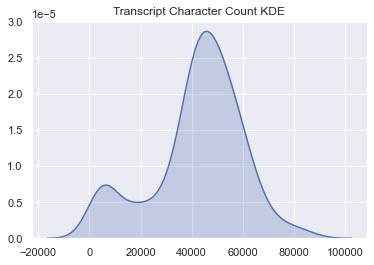

In [10]:
import numpy as np
import seaborn as sns; sns.set(color_codes=True)

# Stats and KDE plot for character count of each transcript
x = [len(x) for x in df.transcript]
ax = sns.kdeplot(x, shade=True, color="b")
ax.set_title('Transcript Character Count KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')